# Jet Types and Algorithms

The jet algorithms take as input a set of 4-vectors. At CMS, the most popular jet type is the "Particle Flow Jet", which attempts to use the entire detector at once and derive single four-vectors representing specific particles.For this reason it is very comparable (ideally) to clustering generator-level four-vectors also.

## Particle Flow Jets (PFJets)

Particle Flow candidates (PFCandidates) combine information from various detectors to make a combined estimation of particle properties based on their assigned identities (photon, electron, muon, charged hadron, neutral hadron).

PFJets are created by clustering PFCandidates into jets, and contain information about contributions of every particle class: Electromagnetic/hadronic, Charged/neutral etc.

The jet response is high. The jet pT resolution is good: starting at 15--20% at low pT and asymptotically reaching 5% at high pT.

## Monte Carlo Generator-level Jets (GenJets)

GenJets are pure Monte Carlo simulated jets. They are useful for analysis with MC samples. GenJets are formed by clustering the four-momenta of Monte Carlo truth particles. This may include “invisible” particles (muons, neutrinos, WIMPs, etc.).

As there are no detector effects involved, the jet response (or jet energy scale) is 1, and the jet resolution is perfect, by definition.

GenJets include information about the 4-vectors of the constituent particles, the hadronic and electromagnetic components of the energy etc.

## Calorimeter Jets (CaloJets)

CaloJets are formed from energy deposits in the calorimeters (hadronic and electromagnetic), with no tracking information considered. In the barrel region, a calorimeter tower consists of a single HCAL cell and the associated 5x5 array of ECAL crystals (the HCAL-ECAL association is similar but more complicated in the endcap region). The four-momentum of a tower is assigned from the energy of the tower, assuming zero mass, with the direction corresponding to the tower position from the interaction point.

In CMS, CaloJets are used less often than PFJets. Examples of their use include performance studies to disentangle tracker and calorimeter effects, and trigger-level analyses where the tracker is neglected to reduce the event processing time. ATLAS makes much more use of CaloJets, as their version of particle flow is not as mature as CMS's.

## Exercise: Reconstructed vs. Generator-Level Jets

### Loading libraries
We will use the [coffea package](https://coffeateam.github.io/coffea) and all the newest pythonic libraries:

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

In [2]:
fname = "root://xrootd-cms.infn.it//store/mc/RunIISummer20UL18NanoAODv9/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2520000/47A0D984-2D6F-0D42-B5CB-906786434349.root"
events = NanoEventsFactory.from_root( fname, schemaclass=NanoAODSchema.v6).events()

Plugin version SecClnt v5.5.0 is incompatible with secztn v5.6.2 (must be <= 5.5.x) in sec.protocol libXrdSecztn-5.so


In [3]:
hists = (
    hist.Hist.new
    .StrCat(["pf", "gen", "calo"], name="jet_type")
    .Reg(50, 0, 500, name="pt")
    .Reg(40, -5, 5, name="eta")
    .Reg(40, -5, 5, name="phi")
    .Reg(20, 0, 100, name="mass")
    .Weight()
    .fill(
        jet_type="pf",
        pt=ak.flatten(events.Jet.pt),
        eta=ak.flatten(events.Jet.eta),
        phi=ak.flatten(events.Jet.phi),
        mass=ak.flatten(events.Jet.mass)    
    )
    .fill(
        jet_type="gen",
        pt=ak.flatten(events.GenJet.pt),
        eta=ak.flatten(events.GenJet.eta),
        phi=ak.flatten(events.GenJet.phi),
        mass=ak.flatten(events.GenJet.mass)    
    )
#     .fill(
#         jet_type="calo",
#         pt=ak.flatten(events.CaloJet.pt),
#         eta=ak.flatten(events.CaloJet.eta),
#         phi=ak.flatten(events.CaloJet.phi),
#         mass=ak.flatten(events.CaloJet.mass)    
#     )
)


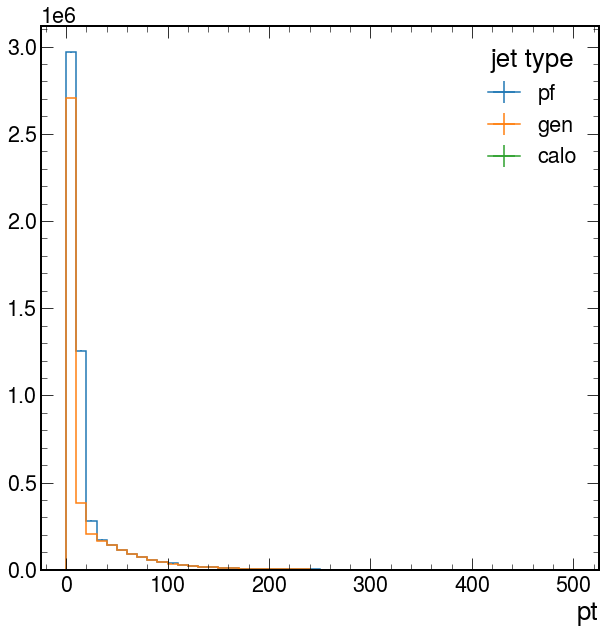

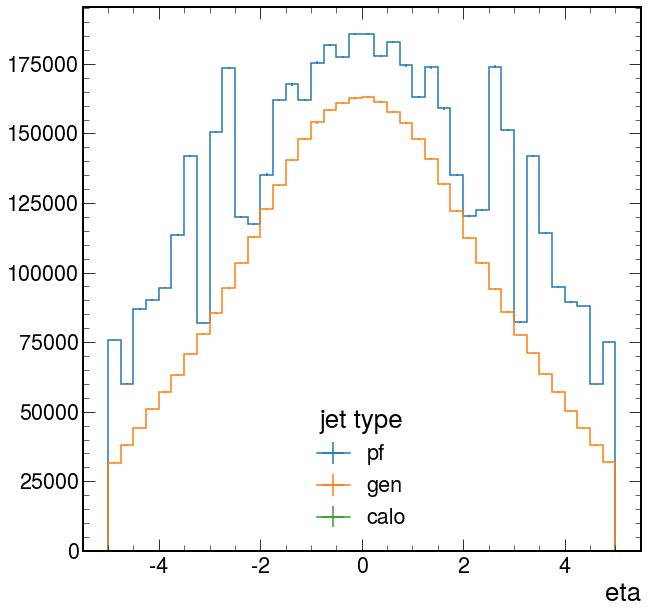

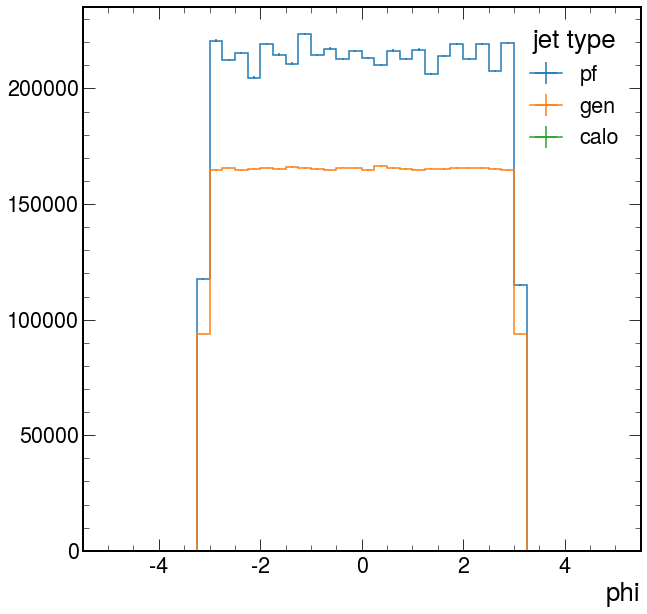

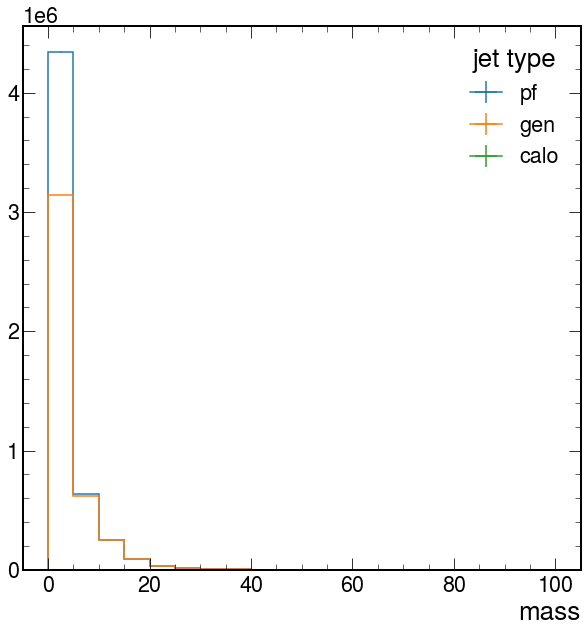

In [4]:
for ivar in ['pt', 'eta', 'phi', 'mass']:
    fig, ax = plt.subplots()
    hists.project("jet_type", ivar).plot1d(ax=ax)
    ax.legend(title="jet type")

As you can see, the agreement isn't very good! Can you guess why?

<details>
<summary>
    <font color='blue'>Show answer...</font>
</summary>
We need to apply the jet energy corrections (JEC), which are described in the next exercise. But before we do that, we'll go over the jet clustering algorithms used in CMS.
</details>

# Jet Clustering Algorithms

The majority of jet algorithms at CMS use a so-called "clustering sequence". This is essentially a pairwise examination of the input four-vectors. If the pair satisfy some criteria, they are merged. The process is repeated until the entire list of constituents is exhausted. In addition, there are several ways to determine the "area" of the jet over which the input constituents lay. This is very important in correcting for pileup, as we will see, because some algorithms tend to "consume" more constituents than others and hence are more susceptible to pileup. Furthermore, the amount of energy that is inside of a jet due to pileup is proportional to the area, so to correct for this effect it is very important to know the jet area.



<img src="../files/JHEP04_2008_063.jpg" alt="" style="width: 600px;"/>
Figure: Comparison of jet areas for four different jet algorithms, from "The anti-kt Clustering Algorithm" by Cacciari, Salam, and Soyez [JHEP04, 063 (2008), arXiv:0802.1189].

Some excellent references about jet algorithms can be found here:

- [Toward Jetography](http://arxiv.org/abs/0906.1833) by Gavin Salam.
- [Jets in Hadron-Hadron Collisions](http://arxiv.org/abs/0712.2447) by Ellis, Huston, Hatakeyama, Loch, and Toennesmann
- [The Catchment Area of Jets](http://arxiv.org/abs/0802.1188) by Cacciari, Salam, and Soyez.
- [The anti-kt Clustering Algorithm](http://arxiv.org/abs/0802.1189) by Cacciari, Salam, and Soyez.


## Exercise: Comparing jet areas between AK4 and AK8

Run the below script 'jet_cone_sizes.py' to plot a comparison of the jets areas between AK4 and AK8 jets. A priori, what type of distribution do you expect?

In [5]:
hists2 = (
    hist.Hist.new
    .StrCat(["ak4", "ak8"], name="jet_type")
    .Reg(50, 0, 500, name="pt")
    .Reg(40, -5, 5, name="eta")
    .Reg(40, -5, 5, name="phi")
    .Reg(20, 0, 100, name="mass")
    .Reg(30, 0, 3, name="area")
    .Weight()
    .fill(
        jet_type="ak4",
        pt=ak.flatten(events.Jet.pt),
        eta=ak.flatten(events.Jet.eta),
        phi=ak.flatten(events.Jet.phi),
        mass=ak.flatten(events.Jet.mass),
        area=ak.flatten(events.Jet.area)    
    )
    .fill(
        jet_type="ak8",
        pt=ak.flatten(events.FatJet.pt),
        eta=ak.flatten(events.FatJet.eta),
        phi=ak.flatten(events.FatJet.phi),
        mass=ak.flatten(events.FatJet.mass),
        area=ak.flatten(events.FatJet.area)
    )
)


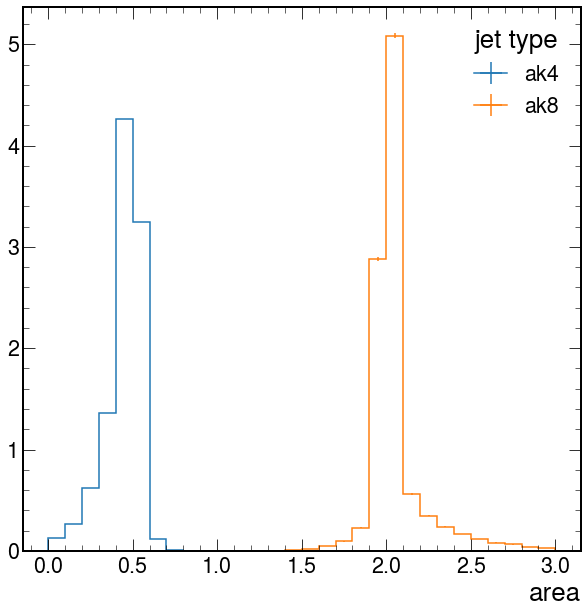

In [6]:
fig, ax = plt.subplots()
hists2.project("jet_type", "area").plot1d(density=True, ax=ax)
ax.legend(title="jet type")

Try modifying the previous cell to add vertical lines at area values corresponding to $\pi R^2$. Do the histogram peaks line up with these values?

<details>
<summary>
    <font color='blue'>Show answer...</font>
</summary>

Add these lines in the cell above:
```
plt.axvline(x=np.pi*(0.4*0.4), color='b', linestyle='--')
plt.axvline(x=np.pi*(0.8*0.8), color='r', linestyle='--')
```
</details>


## Your turn

You can make plots for other quantities between ak4 and ak8 jets.

# Jet ID

In order to avoid using fake jets, which can originate from a hot calorimeter cell or electronic read-out box, we need to require some basic quality criteria for jets. These criteria are collectively called "jet ID". Details on the jet ID for PFJets can be found in the following twiki:

https://twiki.cern.ch/twiki/bin/viewauth/CMS/JetID

The JetMET POG recommends a single jet ID for most physics analysess in CMS, which corresponds to what used to be called the tight Jet ID. Some important observations from the above twiki:

- Jet ID is defined for uncorrected jets only. Never apply jet ID on corrected jets. This means that in your analysis you should apply jet ID first, and then apply JECs on those jets that pass jet ID.
- Jet ID is fully efficient (>99%) for real, high-$p_{\mathrm{T}}$ jets used in most physics analysis. Its background rejection power is similarly high.


## Applying Jet ID

In nanoAOD is trivial to apply jetID. They are stored as Flags, where `events.Jet.jetId>=2` corresponds to *tightID* and `events.Jet.jetId>=6` corresponds to *tightLepVetoID*. 

If you want to know how this flags are stored in nanoAOD, in c++, open the next show.
<details>
<summary>
    <font color='blue'>Show...</font>
</summary>
There are several ways to apply jet ID. In our above exercises, we have run the cuts "on-the-fly" in our python FWLite macro (the first option here). Others are listed for your convenience.

The following examples use somewhat out of date numbers. See the above link to the JetID twiki for the current numbers.

To apply the cuts on pat::Jet (like in miniAOD) in python then you can do : 

<code>
# Apply jet ID to uncorrected jet
nhf = jet.neutralHadronEnergy() / uncorrJet.E()
nef = jet.neutralEmEnergy() / uncorrJet.E()
chf = jet.chargedHadronEnergy() / uncorrJet.E()
cef = jet.chargedEmEnergy() / uncorrJet.E()
nconstituents = jet.numberOfDaughters()
nch = jet.chargedMultiplicity()
goodJet = \
  nhf < 0.99 and \
  nef < 0.99 and \
  chf > 0.00 and \
  cef < 0.99 and \
  nconstituents > 1 and \
  nch > 0
</code>


To apply the cuts on pat::Jet (like in miniAOD) in C++ then you can do:

<summary>
    <font color='blue'>Show...</font>
</summary>
<code>
// Apply jet ID to uncorrected jet
double nhf = jet.neutralHadronEnergy() / uncorrJet.E();
double nef = jet.neutralEmEnergy() / uncorrJet.E();
double chf = jet.chargedHadronEnergy() / uncorrJet.E();
double cef = jet.chargedEmEnergy() / uncorrJet.E();
int nconstituents = jet.numberOfDaughters();
int nch = jet.chargedMultiplicity();
bool goodJet = 
  nhf < 0.99 &&
  nef < 0.99 &&
  chf > 0.00 &&
  cef < 0.99 &&
  nconstituents > 1 &&
  nch > 0;
</code>


To create selected jets in cmsRun:
<details>
<summary>
    <font color='blue'>Show...</font>
</summary>
<code>
from PhysicsTools.SelectorUtils.pfJetIDSelector_cfi import pfJetIDSelector
process.tightPatJetsPFlow = cms.EDFilter("PFJetIDSelectionFunctorFilter",
                                         filterParams = pfJetIDSelector.clone(quality=cms.string("TIGHT")),
                                         src = cms.InputTag("slimmedJets")
                                         )
</code>


It is also possible to use the `PFJetIDSelectionFunctor` C++ selector (actually, either in C++ or python), but this was primarily developed in the days before PF when applying CaloJet ID was not possible very easily. Nevertheless, the functionality of more complicated selection still exists for PFJets, but is almost never used other than the few lines above. If you would still like to use that C++ class, it is documented as an example here.
</details>

Let's create a histogram with the jetId information:

In [7]:
hists3 = (
    hist.Hist.new
    .Reg(50, 0, 500, name="pt")
    .Reg(40, -5, 5, name="eta")
    .Reg(10, 0, 10, name="jetId")
    .Weight()
    .fill(
        pt=ak.flatten(events.Jet.pt),
        eta=ak.flatten(events.Jet.eta),
        jetId=ak.flatten(events.Jet.jetId),
    )
)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb16c3dc1f0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

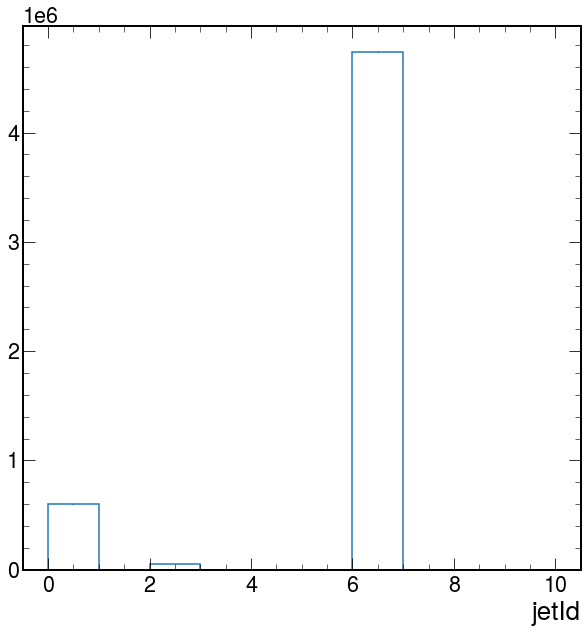

In [8]:
hists3.project("jetId").plot1d()

What do the jets with jetId represent? Were you expecting more or less jets with jetId==0?

Let's apply a simple selection to the `events.Jet` collection to remove those jets:

In [9]:
jets = events.Jet[events.Jet.jetId>=2]

hists4 = (
    hist.Hist.new
    .Reg(50, 0, 500, name="pt")
    .Reg(40, -5, 5, name="eta")
    .Reg(10, 0, 10, name="jetId")
    .Weight()
    .fill(
        pt=ak.flatten(jets.pt),
        eta=ak.flatten(jets.eta),
        jetId=ak.flatten(jets.jetId),
    )
)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fb160432250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

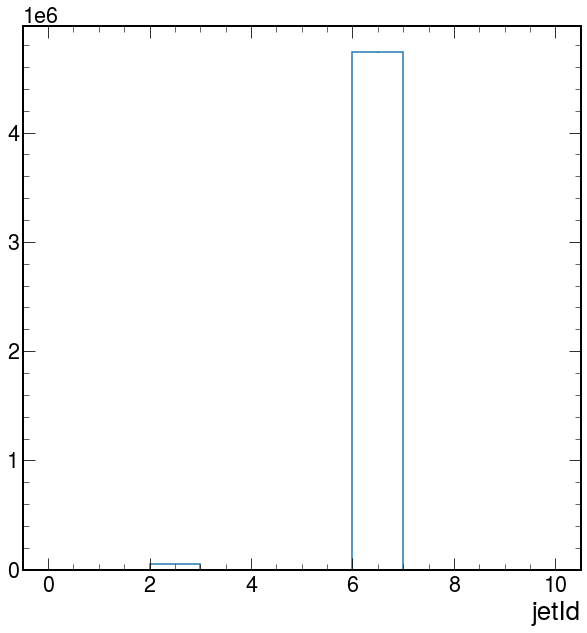

In [10]:
hists4.project("jetId").plot1d()

## Your turn

How different do the other jet distributions look like with jetId implemented?